# Chunking and Tile Streaming

This notebook explores how to chunk the raster files to load only windows at a time in memory. In addition to chunking the tiles we also explore masking out water based and partial chunks out and that land tiles are properly preserved. Finally we look at saving the new chunk shape data to have geospatial metadata for the individual chunks.

In [2]:
import os
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from rasterio.windows import bounds, Window
from rasterio.features import geometry_mask
from shapely.geometry import box
from dotenv import load_dotenv

In [ ]:
load_dotenv()

## Load shape data

In [ ]:
root = os.getenv('DATA_ROOT')

In [3]:
# California block 1 & 9 shape data
ca_data_01 = f'{root}/data/CA/california_R01C01'
ca_data_09 = f'{root}/data/CA/california_R01C09'
ca_data_til = f'{ca_data_01}/tile_index.shp'
ca_data_01_shp = f'{ca_data_01}/california_R01C01.shp'
ca_data_01_tif = f'{ca_data_01}/california_R01C01.tif'
ca_data_09_shp = f'{ca_data_09}/california_R01C09.shp'

# US shape data
us_data_shp = f'{root}/natural_earth_vector/110m_cultural/ne_110m_admin_1_states_provinces.shp'

Load the CA state data

In [4]:
us = gpd.read_file(us_data_shp)
ca = us[us.name.eq('California')]

In [5]:
ca.head()

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,FCLASS_TLC,geometry
7,Admin-1 scale rank,2,USA-3521,3521,US-CA,http://en.wikipedia.org/wiki/California,US,8,California,CA|Calif.,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-114.64222 35.05311, -114.62212 34.9..."


Load the first block of CA [R1, C1]

In [7]:
r01_df = gpd.read_file(ca_data_01_shp)
r09_df = gpd.read_file(ca_data_09_shp)
til_df = gpd.read_file(ca_data_til)

In [8]:
r01_df.head()

,Link,Date,Photo_ID,geometry
0,https://earthexplorer.usgs.gov/scene/metadata/...,1952/09/01,1QD0000020032,"MULTIPOLYGON (((-124.38528 42.04116, -124.3717..."
1,https://earthexplorer.usgs.gov/scene/metadata/...,1952/09/01,1QD0000020085,"MULTIPOLYGON (((-124.31232 42.04116, -124.3065..."
2,https://earthexplorer.usgs.gov/scene/metadata/...,1952/09/01,1QD0000020086,"POLYGON ((-124.3616 42.02577, -124.36132 42.02..."
3,https://earthexplorer.usgs.gov/scene/metadata/...,1952/09/01,1QD0000040113,"MULTIPOLYGON (((-124.00223 42.03492, -124.0021..."
4,https://earthexplorer.usgs.gov/scene/metadata/...,1952/09/01,1QD0000040114,"POLYGON ((-124.00387 42.01893, -124.00352 42.0..."


In [9]:
til_df.head()

,col,row,id,state,url,geometry
0,11,18,R18C11,California,https://download.landscapeexplorer.org/data/ra...,"POLYGON ((-119.11661 32.33935, -119.11661 32.8..."
1,12,18,R18C12,California,https://download.landscapeexplorer.org/data/ra...,"POLYGON ((-118.57762 32.33935, -118.57762 32.8..."
2,14,18,R18C14,California,https://download.landscapeexplorer.org/data/ra...,"POLYGON ((-117.49964 32.33935, -117.49964 32.8..."
3,15,18,R18C15,California,https://download.landscapeexplorer.org/data/ra...,"POLYGON ((-116.96065 32.33935, -116.96065 32.8..."
4,16,18,R18C16,California,https://download.landscapeexplorer.org/data/ra...,"POLYGON ((-116.42166 32.33935, -116.42166 32.8..."


In [10]:
r01_df.shape, til_df.shape

((79, 4), (191, 6))

## Tile Views

Overview of the CA Tile breakdown and the first tile

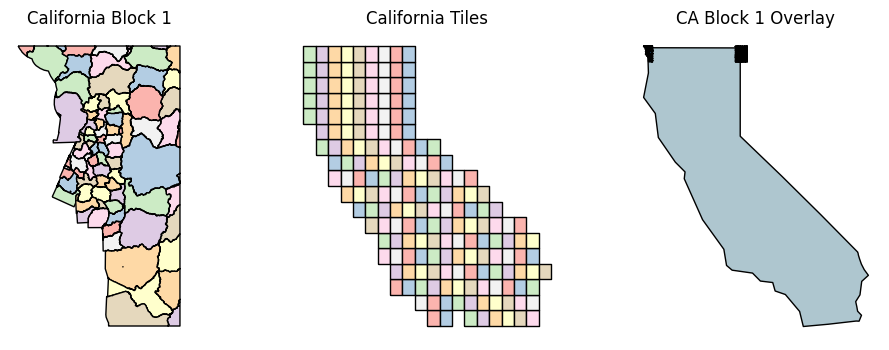

In [11]:
cmap = sns.color_palette(palette='Pastel1', as_cmap=True)
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

r01_df.plot(ax=axs[0], cmap=cmap, edgecolor='black')
axs[0].set_title('California Block 1')
axs[0].axis('off')

til_df.plot(ax=axs[1], cmap=cmap, edgecolor='black')
axs[1].set_title('California Tiles')
axs[1].axis('off')

ca.plot(ax=axs[2], color='#AEC6CF', edgecolor='black')
r01_df.plot(ax=axs[2], edgecolor='black')
r09_df.plot(ax=axs[2], edgecolor='black')
axs[2].set_title('CA Block 1 Overlay')
axs[2].axis('off')

plt.show()

## Load the TIF data

In [11]:
tif = rasterio.open(ca_data_01_tif)

In [12]:
block_1, window = next(tif.block_windows(1))

In [13]:
window_transform = tif.window_transform(window=window)
chunk_1 = tif.read(window=window)

masked = geometry_mask(ca['geometry'],
                       out_shape=(chunk_1.shape[1], chunk_1.shape[2]),
                       transform=window_transform,
                       invert=True)

In [14]:
masked

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

Display the chunk

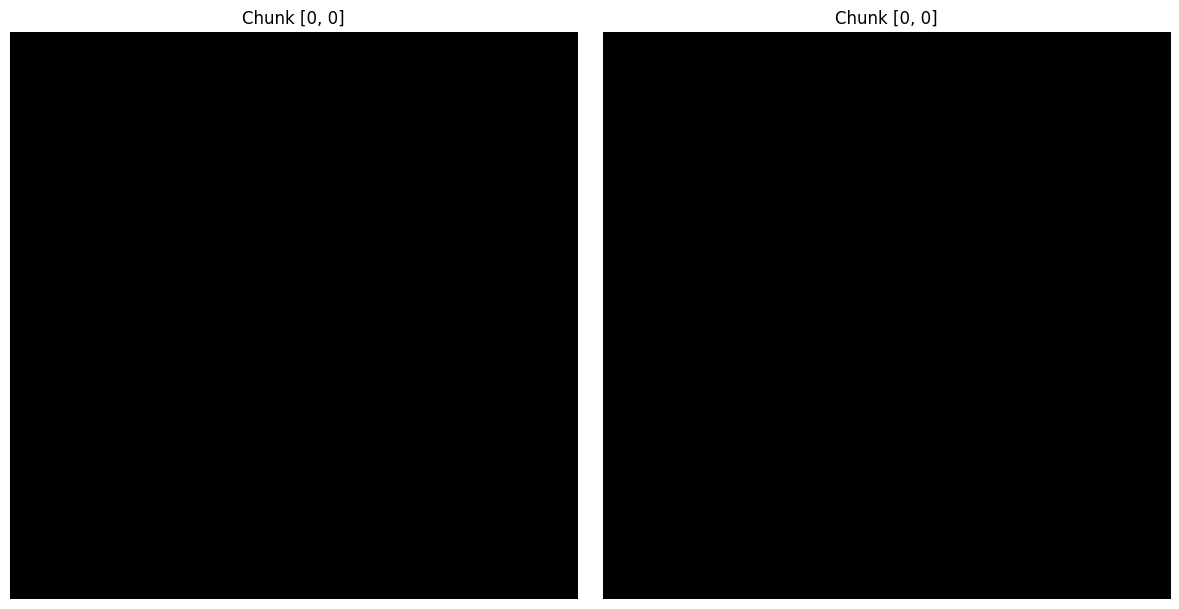

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(chunk_1[0], cmap='gray')
axs[0].set_title(f'Chunk [{block_1[0]}, {block_1[1]}]')
axs[0].axis('off')

masked_im = np.clip(chunk_1[0] - (~masked * 255), 0, 255)
axs[1].imshow(masked_im, cmap='gray')
axs[1].set_title(f'Chunk [{block_1[0]}, {block_1[1]}]')
axs[1].axis('off')

plt.tight_layout()
plt.show()

The empty tiles are correctly masked out

## Water Masking

In [16]:
water_block = (76, 98)
water_window = Window(col_off=water_block[1]*256, row_off=water_block[0]*256, width=256, height=256)

In [17]:
window_transform = tif.window_transform(window=water_window)
water_chunk = tif.read(window=water_window)

water_masked = geometry_mask(ca['geometry'],
                            out_shape=(water_chunk.shape[1], water_chunk.shape[2]),
                            transform=window_transform,
                            invert=True)

In [18]:
water_masked

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

Display the water chunk

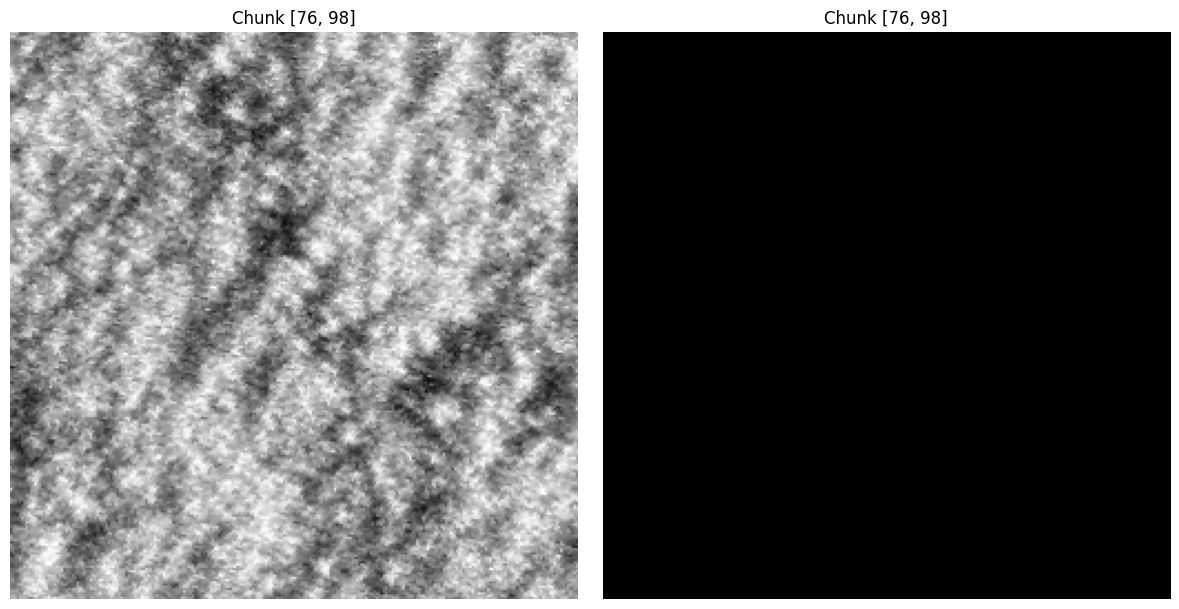

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(water_chunk[0], cmap='gray')
axs[0].set_title(f'Chunk [{water_block[0]}, {water_block[1]}]')
axs[0].axis('off')

masked_im = np.clip(water_chunk[0] - (~water_masked * 255), 0, 255)
axs[1].imshow(masked_im, cmap='gray')
axs[1].set_title(f'Chunk [{water_block[0]}, {water_block[1]}]')
axs[1].axis('off')

plt.tight_layout()
plt.show()

This is the expected masking which is what we want to see, the mask will remove the water tile

## Partial Water Masking

In [20]:
part_water_block = (76, 129)
part_water_window = Window(col_off=part_water_block[1]*256, row_off=part_water_block[0]*256, width=256, height=256)

In [21]:
window_transform = tif.window_transform(window=part_water_window)
part_water_chunk = tif.read(window=part_water_window)

part_water_masked = geometry_mask(ca['geometry'],
                            out_shape=(part_water_chunk.shape[1], part_water_chunk.shape[2]),
                            transform=window_transform,
                            invert=True)

In [22]:
part_water_masked

array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

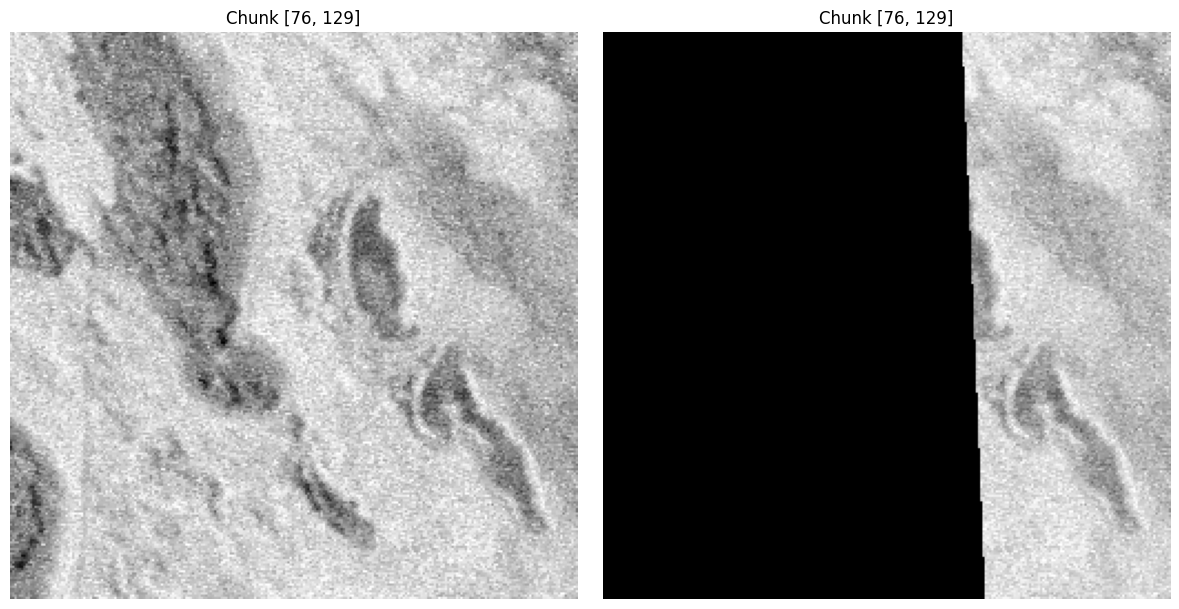

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(part_water_chunk[0], cmap='gray')
axs[0].set_title(f'Chunk [{part_water_block[0]}, {part_water_block[1]}]')
axs[0].axis('off')

masked_im = np.clip(part_water_chunk[0] - (~part_water_masked * 255), 0, 255)
axs[1].imshow(masked_im, cmap='gray')
axs[1].set_title(f'Chunk [{part_water_block[0]}, {part_water_block[1]}]')
axs[1].axis('off')

plt.tight_layout()
plt.show()

Observed a few patterns here, it appears to filter out some of the coastline until it hits a more solid area, however this does not create a clean chunk meaning we need to decide on a strategy for partial masks

## Land Masking

One last check where we expect to nothing to be filtered out when over land

In [24]:
land_block = (76, 131)
land_window = Window(col_off=land_block[1]*256, row_off=land_block[0]*256, width=256, height=256)

In [25]:
window_transform = tif.window_transform(window=land_window)
land_chunk = tif.read(window=land_window)

land_masked = geometry_mask(ca['geometry'],
                            out_shape=(land_chunk.shape[1], land_chunk.shape[2]),
                            transform=window_transform,
                            invert=True)

In [26]:
land_masked

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

Display the land chunk

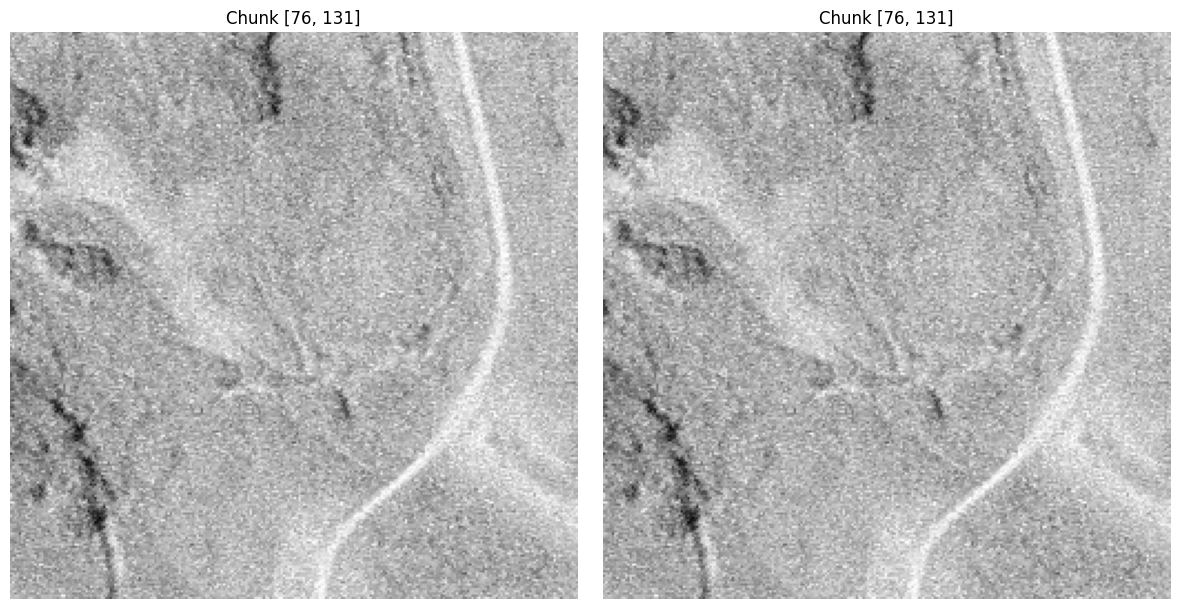

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(land_chunk[0], cmap='gray')
axs[0].set_title(f'Chunk [{land_block[0]}, {land_block[1]}]')
axs[0].axis('off')

masked_im = np.clip(land_chunk[0] - (~land_masked * 255), 0, 255)
axs[1].imshow(masked_im, cmap='gray')
axs[1].set_title(f'Chunk [{land_block[0]}, {land_block[1]}]')
axs[1].axis('off')

plt.tight_layout()
plt.show()

Here we see the land chunks remain after boundary masking as expected

## Chunk Shaping

Grab the original land box tile

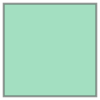

In [321]:
land_box = box(*bounds(land_window, tif.transform))
land_box

Create a new shape file with our masked geometry

In [339]:
new_shp = gpd.GeoDataFrame({
    'geometry': [land_box],
    'state': ['California'],
    'tile_id': ['R01C01']
}, crs=r01_df.crs)

In [341]:
new_shp.head()

,geometry,masked
0,"POLYGON ((-124.20294 41.86408, -124.20294 41.8...",True


Intersect it with the revelant tile to get the source image and meta data

In [345]:
r01_chunk_df = gpd.overlay(r01_df, new_shp, how='intersection')

In [346]:
r01_chunk_df.head()

,Link,Date,Photo_ID,masked,geometry
0,https://earthexplorer.usgs.gov/scene/metadata/...,1955/07/27,1VIU000010018,True,"POLYGON ((-124.20524 41.86408, -124.20524 41.8..."


Visualize the chunk against the tile

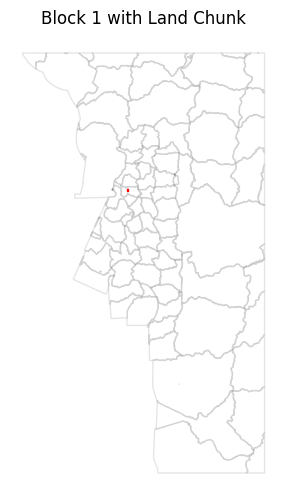

In [347]:
fig, axs = plt.subplots(1, 1, figsize=(6, 6))

r01_df.plot(ax=axs, color='white', edgecolor='gray', alpha=0.2)
r01_chunk_df.plot(ax=axs, color='red', edgecolor='red')
plt.title('Block 1 with Land Chunk')
plt.axis('off')
plt.show()

In [ ]:
# Example of saving it down to shp file
# r01_chunk_df.to_file(f'{ca_data_01}/land_chunk.shp')

Remember to release the file when done

In [348]:
tif.close()